In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from scipy import optimize

import tensorflow as tf
import torch
import os
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
from supervised import read_csv, prepare_data, TickerDataSimple

--- log folder exists


In [5]:
X_all, Y = prepare_data('spy', True)
input = pd.DataFrame(X_all.iloc[:, 1:])

# Random sequence data
# train_idx, test_idx = train_test_split(np.arange(len(input)))

# Sequential data
length = int(len(input)* 0.8)
train_idx = np.arange(length)
test_idx = np.arange(length, len(input))

In [6]:
train_df = input.iloc[train_idx]
test_df = input.iloc[test_idx]
print(train_idx.shape, test_idx.shape)
print(train_df.shape, test_df.shape)
# Consider some other y transfroms...
y_train = np.where(Y[train_idx]>0, 1, 0)
y_test = np.where(Y[test_idx]>0, 1, 0)
y_train.sum(), y_test.sum()

(2520,) (631,)
(2520, 24) (631, 24)


(1538, 377)

In [7]:
# Use only the ones worked well in autoencoder
transfomer = [
    ('Data after min-max scaling',
        MinMaxScaler()),
    ('Data after max-abs scaling',
        MaxAbsScaler()),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')),
    ('Data after sample-wise L2 normalizing',
        Normalizer()),
]

combined = FeatureUnion(transfomer)
combined_fit = combined.fit(train_df)

In [8]:
x_train_transformed = combined.transform(train_df)
x_test_transformed = combined.transform(test_df)

In [9]:
x_train_transformed.shape, x_test_transformed.shape

((2520, 96), (631, 96))

#### Time for a simple regression

This is actually a terrible idea in a way. Input_size of 96 makes the first layer already 96*24 for the matmul... <~ 2400 params... Our training set is only of size 2520.

In [10]:
class LogisticRegressor(nn.Module):
    def __init__(self, input_size, final_output_size):
        super(LogisticRegressor, self).__init__()

        self.l1 = nn.Linear(input_size, 24)
        self.l2 = nn.Linear(24, 12)
        self.l3 = nn.Linear(12, 6)
        self.l4 = nn.Linear(6, 1)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = torch.tanh(self.l3(x))
        return torch.sigmoid(self.l4(x))

In [11]:
x_train_transformed = combined.transform(train_df)
x_test_transformed = combined.transform(test_df)

spy_dataset = TickerDataSimple('spy', x_train_transformed, y_train)

BATCH_SIZE = 64
train_dl = DataLoader(spy_dataset, 
                      num_workers=1, 
                      batch_size=BATCH_SIZE)

spy_testset = TickerDataSimple('spy', x_test_transformed, y_test)

BATCH_SIZE = 64
test_dl = DataLoader(spy_testset, 
                      num_workers=1, 
                      batch_size=BATCH_SIZE)

In [67]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()
        
    def forward(self, y_pred, y_target):
        return F.binary_cross_entropy(y_pred, y_target)*torch.mean(1-y_pred)
        return torch.mean(torch.pow(y_pred - y_target, 2))

In [68]:
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

# Each Data Points are 24 (6 * 4)
# Transformer has 4 different ways
model = LogisticRegressor(24 * 4, 1)

criterion = nn.modules.loss.BCELoss()
# criterion = CustomLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-6)

In [69]:
import ignite
from ignite.metrics import BinaryAccuracy, Loss, Precision, Recall
from ignite.engine import Events, \
                          create_supervised_trainer, \
                          create_supervised_evaluator

In [70]:
import sklearn.metrics as sk_metrics
import torch.nn.functional as F

In [101]:
iter_train_dl = iter(train_dl)

f1_score: 0.7250000000000001
accuracy_score: 0.65625
roc_auc_score: 0.7966764418377321


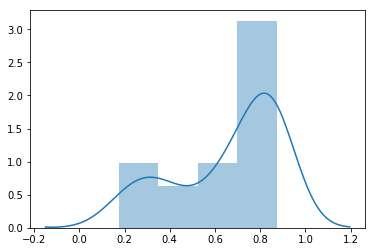

In [144]:
x, y = next(iter_train_dl)
_out = model(x)
_zero_one = _out > 0.5
print('f1_score: {}'.format(sk_metrics.f1_score(_zero_one.detach().numpy(), y)))
print('accuracy_score: {}'.format(sk_metrics.accuracy_score(_zero_one, y)))
print('roc_auc_score: {}'.format(sk_metrics.roc_auc_score(y, _out.detach().numpy())))
sns.distplot(_out.detach().numpy())

In [73]:
from ignite.metrics import Accuracy
from functools import partial
from sklearn.metrics import roc_auc_score
from ignite.metrics import EpochMetric


def sk_metric_fn(y_preds, y_targets, sk_metrics, activation=None):
    y_true = y_targets.numpy()
    if activation is not None:
        y_preds = activation(y_preds)
    y_pred = y_preds.numpy()
    return sk_metrics(y_true, y_pred)

class ROC_AUC(EpochMetric):
    def __init__(self, activation=None, output_transform=lambda x: x):
        super(ROC_AUC, self).__init__(
            partial(sk_metric_fn, 
                    sk_metrics=sk_metrics.roc_auc_score, 
                    activation=activation),
            output_transform=output_transform)

class F1_Score(EpochMetric):
    def __init__(self, activation=None, output_transform=lambda x: x):
        super(F1_Score, self).__init__(
            partial(sk_metric_fn, 
                    sk_metrics=sk_metrics.f1_score, 
                    activation=activation),
            output_transform=output_transform)


In [74]:
def zero_one(y_preds):
    return y_preds > 0.5

def zero_one_transform(output):
    return (zero_one(output[0])).long(), output[1].long()

In [75]:
trainer = create_supervised_trainer(model, optimizer, criterion)
evaluator = create_supervised_evaluator(
    model,
    metrics={
        'accuracy': Accuracy(output_transform=zero_one_transform),
        'bce':      Loss(criterion),
        'f1_score': F1_Score(activation=zero_one),
        'roc_auc' : ROC_AUC(),
    })

In [76]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dl)
    metrics = evaluator.state.metrics
    print("Training Results  - Epoch: {} Avg accuracy: {:.5f}, Avg loss: {:.5f}, F1 Score: {:.5f}, ROC_AUC: {:.5f}".format(trainer.state.epoch, 
                  metrics['accuracy'], 
                  metrics['bce'],
                  metrics['f1_score'],
                  metrics['roc_auc'],
                 ))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(test_dl)
    metrics = evaluator.state.metrics
    print("Validation Results- Epoch: {} Avg accuracy: {:.5f}, Avg loss: {:.5f}, F1 Score: {:.5f}, ROC_AUC: {:.5f}".format(trainer.state.epoch, 
                  metrics['accuracy'], 
                  metrics['bce'],
                  metrics['f1_score'],
                  metrics['roc_auc'],
                 ))

In [77]:
trainer.run(train_dl, max_epochs=10)

Training Results  - Epoch: 1 Avg accuracy: 0.61032, Avg loss: 0.66795, F1 Score: 0.75801, ROC_AUC: 0.72371
Validation Results- Epoch: 1 Avg accuracy: 0.59746, Avg loss: 0.67267, F1 Score: 0.74802, ROC_AUC: 0.68558
Training Results  - Epoch: 2 Avg accuracy: 0.61706, Avg loss: 0.63855, F1 Score: 0.76096, ROC_AUC: 0.75865
Validation Results- Epoch: 2 Avg accuracy: 0.59746, Avg loss: 0.65123, F1 Score: 0.74802, ROC_AUC: 0.73232
Training Results  - Epoch: 3 Avg accuracy: 0.69802, Avg loss: 0.59328, F1 Score: 0.79293, ROC_AUC: 0.78615
Validation Results- Epoch: 3 Avg accuracy: 0.67036, Avg loss: 0.61306, F1 Score: 0.78059, ROC_AUC: 0.76802
Training Results  - Epoch: 4 Avg accuracy: 0.73770, Avg loss: 0.55217, F1 Score: 0.80689, ROC_AUC: 0.80095
Validation Results- Epoch: 4 Avg accuracy: 0.73376, Avg loss: 0.57505, F1 Score: 0.81250, ROC_AUC: 0.78530
Training Results  - Epoch: 5 Avg accuracy: 0.74881, Avg loss: 0.53474, F1 Score: 0.81155, ROC_AUC: 0.80738
Validation Results- Epoch: 5 Avg accu

In [38]:
evaluator.state.metrics

{'accuracy': 0.40253565768621236,
 'bce': 0.01444854362382186,
 'f1_score': 0.0,
 'roc_auc': 0.487014139810773}